In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd 
import geopandas as gpd 

import rasterio       # For reading .tif files
import matplotlib.pyplot as plt  # For plotting
import numpy as np
import pdb 
import xarray as xr

import rioxarray as xrio
import importlib 
import cv2 

In [2]:
import sys
sys.path.append('./')
import project3_tools

In [3]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [4]:
#load burn area
ba = gpd.read_file('/data/IMFSE/PythonCourse/PontdeVilomara/burntArea/burnAreaPdV2022.shp')

In [5]:
#input files
file_f = '/data/IMFSE/PythonCourse/LCP/lcp_pgd80.tif'
file_atm = '/data/IMFSE/PythonCourse/MNH/FCAST_model3.nc'


In [6]:
#load terrain from fire
ds_f = xrio.open_rasterio(file_f, decode_times=False)
terrain_f = ds_f.isel(band=0)
mask=np.where(terrain_f.values==-9999,0,1).astype(np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, np.ones((21,21))) # to remove point on the border
terrain_f.values[np.where(mask==0)]=-9999

terrain_f_ori = terrain_f.copy()
terrain_f_ori.values[np.where(mask==0)]=-9999

In [7]:
#load terrain from atm from netcdf and set topo in xr dataArray with crs 4326
ds_atm = xr.open_dataset(file_atm, decode_times=False)
terrain_atm = ds_atm.topography
lat_atm = ds_atm.lat.values[:,0]
lon_atm = ds_atm.lon.values[0,:]

terrain_atm_wgs= xr.DataArray(
    terrain_atm.values, 
    coords=[("y", lat_atm), ("x", lon_atm)],  # Assign coordinates
    dims=["y", "x"],  # Define dimension names
#    attrs={"crs": "EPSG:4326"}  # Add CRS as an attribute (EPSG:4326 = WGS 84)
)

terrain_atm_wgs = terrain_atm_wgs.rio.write_crs("EPSG:4326",inplace=True)


In [8]:
#show raster info
print_raster(terrain_f)
print_raster(terrain_atm_wgs)

shape: (726, 700)
resolution: (20.0, -20.0)
bounds: (401252.3826, 4610395.6528, 415252.3826, 4624915.6528)
sum: -247972243
CRS: EPSG:25831

shape: (150, 150)
resolution: (0.0009665729747806074, 0.0007216149609780911)
bounds: (1.8253723664929278, 41.651675360032264, 1.9703583127100188, 41.75991760417898)
sum: 8105614.208960215
CRS: EPSG:4326



<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

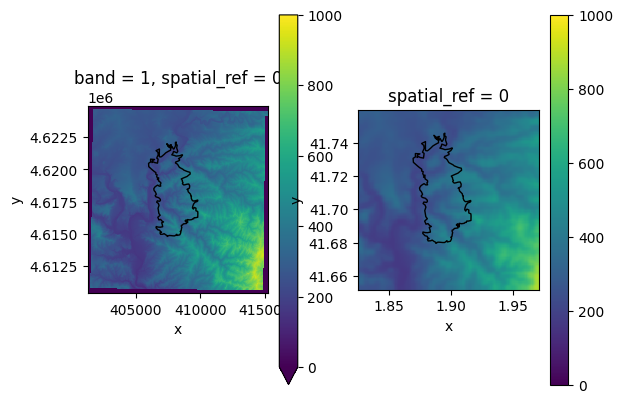

In [9]:
#plot raster with ba
ax = plt.subplot(121)
terrain_f.plot(ax=ax,vmin=0, vmax=1000)
#ba reprojected to terrain_f crs
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='k', facecolor='none')

ax = plt.subplot(122)
terrain_atm_wgs.plot(ax=ax,vmin=0, vmax=1000)
ba.plot(ax=ax,edgecolor='k', facecolor='none')

In [10]:
# Now reproject the terrain_atm_wgs 
#to a the same projection and extdend as terrain_f
terrain_atm = terrain_atm_wgs.rio.reproject_match(terrain_f, nodata=-9999)

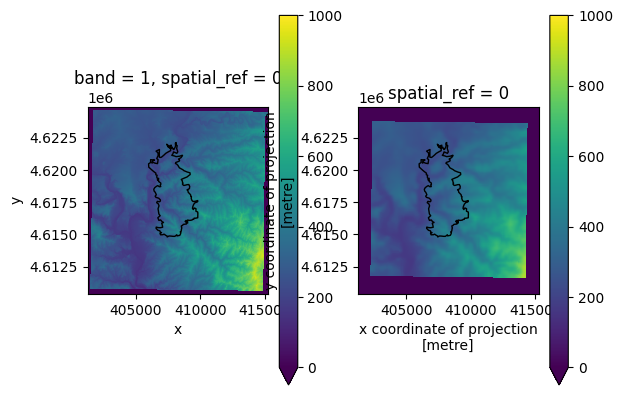

In [11]:
#plot
ax = plt.subplot(121)
terrain_f.plot(vmin=0,vmax=1000,ax=ax)
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='k', facecolor='none')
ax.set_aspect(1)
ax = plt.subplot(122)
terrain_atm.plot(vmin=0,vmax=1000,ax=ax)
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='k', facecolor='none')
ax.set_aspect(1)

In [12]:
#show raster info
print_raster(terrain_f)
print_raster(terrain_atm)

shape: (726, 700)
resolution: (20.0, -20.0)
bounds: (401252.3826, 4610395.6528, 415252.3826, 4624915.6528)
sum: -247972243
CRS: EPSG:25831

shape: (726, 700)
resolution: (20.0, -20.0)
bounds: (401252.3826, 4610395.6528, 415252.3826, 4624915.6528)
sum: -1325673559.9103634
CRS: EPSG:25831



Text(0, 0.5, 'topo atm')

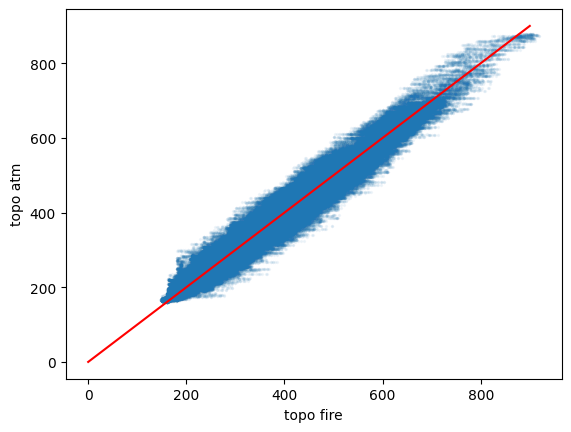

In [13]:
#plot correlation
idxdata = np.where(terrain_atm!=-9999)
ax = plt.subplot(111)
ax.scatter(terrain_f.values[idxdata], terrain_atm.values[idxdata],alpha=.05, s=2)
ax.plot([0,900],[0,900],c='r')
ax.set_xlabel('topo fire')
ax.set_ylabel('topo atm')


In [14]:
file_srtm = '/data/IMFSE/PythonCourse/LCP/srtm30m_pdV.tif'
#load terrain from fire
ds_srtm = xrio.open_rasterio(file_srtm, decode_times=False)
terrain_srtm = ds_srtm.isel(band=0)
terrain_srtm = terrain_srtm.rio.reproject_match(terrain_f, nodata=-9999)

In [15]:
importlib.reload(project3_tools)
terrain_f_aligned, translation = project3_tools.aligned_terrain(terrain_f, terrain_srtm)

In [16]:
translation

array([  92.04063, -207.07222], dtype=float32)

In [17]:
maskBA = project3_tools.create_mask_from_ba( terrain_f, ba)

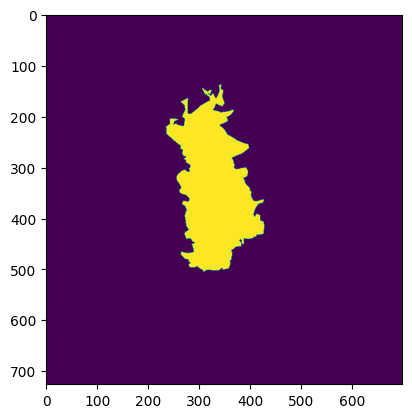

In [18]:
plt.imshow(maskBA)

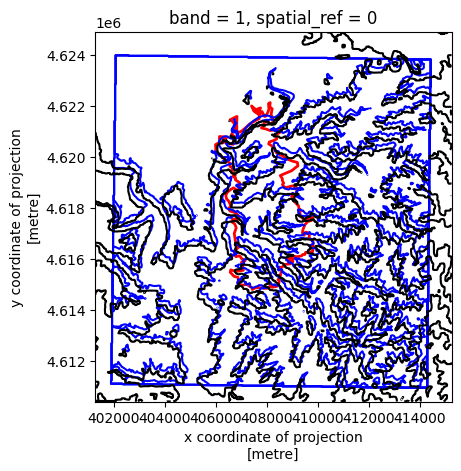

In [19]:
#plot aligned terrain
levels = np.linspace(0, 1000, 10)
ax = plt.subplot(111)
terrain_f_aligned.plot.contour(levels=levels,cmap='b',ax=ax)
terrain_srtm.plot.contour(levels=levels,ax=ax,cmap='k')
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='r', facecolor='none',linewidth=2)
ax.set_aspect(1)